## dbt performance

We're going to track cpu usage over time by running dbt commands in a container. We're also interested in the delay between parsing all of the models and the start of the first run of a model (when dbt establishes a connection) which is why we will be printing out some relevant log lines after the `dbt build` command generates those logs.

In [1]:
import os
import subprocess
import json
import requests_unixsocket
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import altair as alt
alt.renderers.enable('mimetype') # required for charts in GitHub notebook renders.

RendererRegistry.enable('mimetype')

In [2]:
cwd = os.getcwd()

def run_with_num_cpu(num=None):
    """Run commands in containers and poll the socket for the containers stats."""

    cmd = f"rm -rf {cwd}/01_2000_simple_models/logs".split(" ")
    clear_logs = subprocess.Popen(cmd)
    clear_logs.wait()

    if num:
        cmd = f"docker run -d -t --name dbt_app --rm --cpus {num} -p 8580:8580 -v {cwd}/01_2000_simple_models:/app dbt-app-1.0".split()
    else:
        cmd = f"docker run -d -t --name dbt_app --rm -p 8580:8580 -v {cwd}/01_2000_simple_models:/app dbt-app-1.0".split() 
    run_container = subprocess.Popen(cmd, stdout=subprocess.DEVNULL)
    run_container.wait()

    cmd = "docker exec dbt_app dbt --no-partial-parse build -s node_0".split(" ")
    run_build = subprocess.Popen(cmd, stdout=subprocess.DEVNULL)

    session = requests_unixsocket.Session()
    data = []

    while not run_build.poll():
        r = session.get('http+unix://%2Fvar%2Frun%2Fdocker.sock/containers/dbt_app/stats?stream=false')
        data.append(r.json())

    cmd = "docker kill dbt_app".split(" ")
    kill = subprocess.Popen(cmd, stdout=subprocess.PIPE)
    kill.wait()
    return data, num

def generate_chart(data):
    """Format the data and do some math to calculate CPU usage percentage.

    The calculations for CPU percentage is from https://docs.docker.com/engine/api/v1.41/#tag/Container/operation/ContainerStats
    """

    df = pd.json_normalize(data[0])
    cpu_stats = df.loc[:, ["read", "cpu_stats.online_cpus", "cpu_stats.cpu_usage.total_usage", "precpu_stats.cpu_usage.total_usage", "cpu_stats.system_cpu_usage", "precpu_stats.system_cpu_usage"]]
    cpu_stats["cpu_delta"] = cpu_stats["cpu_stats.cpu_usage.total_usage"] - cpu_stats["precpu_stats.cpu_usage.total_usage"]
    cpu_stats["system_cpu_delta"] = cpu_stats["cpu_stats.system_cpu_usage"] - cpu_stats["precpu_stats.system_cpu_usage"]
    cpu_stats["cpu_usage_perc"] = (cpu_stats["cpu_delta"] / cpu_stats["system_cpu_delta"]) * cpu_stats["cpu_stats.online_cpus"] * 100
    cpu_stats["read"] = pd.to_datetime(cpu_stats["read"]).dt.tz_localize(None)

    return alt.Chart(cpu_stats).mark_line().encode(
        x=alt.X("yearmonthdatehoursminutesseconds(read):O", axis=alt.Axis(labelAngle=-90, format="%H:%M:%S")), 
        y="cpu_usage_perc"
    ).properties(
        width=800,
        height=400,
        title=f"Container with {data[1]} cpu limit"
    )

def print_relevant_logs():
    """Print relevant log lines to check timing."""
    with open(f"{cwd}/01_2000_simple_models/logs/dbt.log", "r") as f:
        all_lines = f.readlines()
    start = [s for s in all_lines if "Found" in s][0]
    end = [s for s in all_lines if "Acquiring new postgres connection" in s][0]
    print(start + end)

19:28:20.279921 [info ] [MainThread]: Found 2000 models, 6000 tests, 0 snapshots, 0 analyses, 165 macros, 0 operations, 0 seed files, 0 sources, 0 exposures, 0 metrics
19:28:21.605619 [debug] [MainThread]: Acquiring new postgres connection "master"



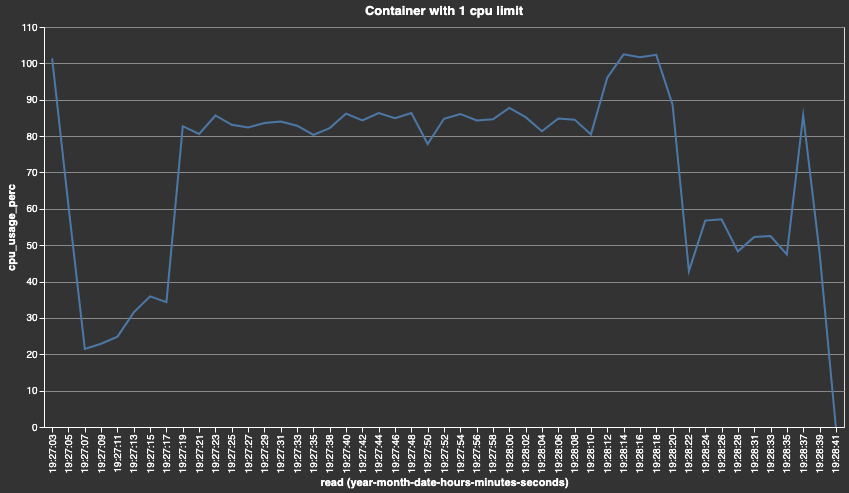

In [3]:
chart = generate_chart(run_with_num_cpu(1))
print_relevant_logs()
chart

19:30:53.983262 [info ] [MainThread]: Found 2000 models, 6000 tests, 0 snapshots, 0 analyses, 165 macros, 0 operations, 0 seed files, 0 sources, 0 exposures, 0 metrics
19:30:57.432708 [debug] [MainThread]: Acquiring new postgres connection "master"



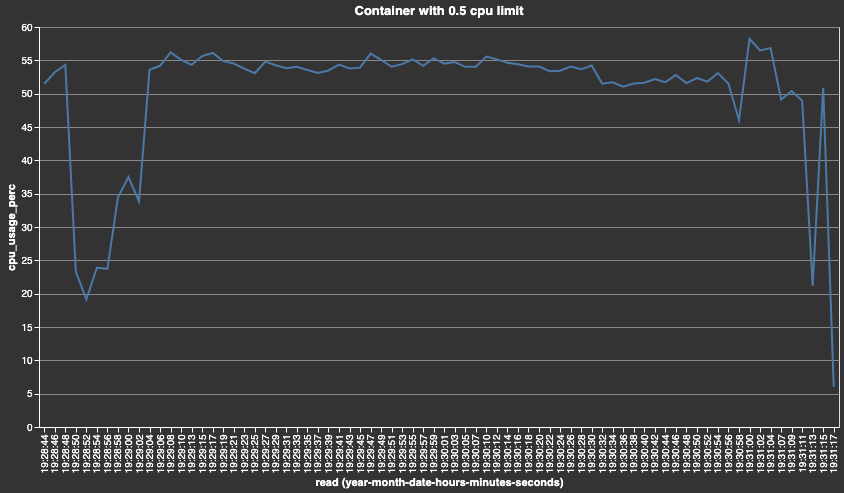

In [4]:
chart = generate_chart(run_with_num_cpu(0.5))
print_relevant_logs()
chart

19:43:57.254739 [info ] [MainThread]: Found 2000 models, 6000 tests, 0 snapshots, 0 analyses, 165 macros, 0 operations, 0 seed files, 0 sources, 0 exposures, 0 metrics
19:44:19.448138 [debug] [MainThread]: Acquiring new postgres connection "master"



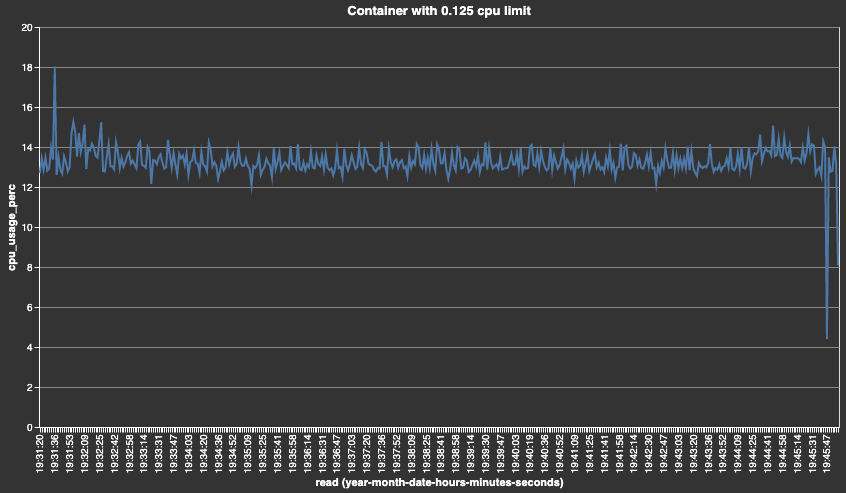

In [5]:
chart = generate_chart(run_with_num_cpu(0.125))
print_relevant_logs()
chart

19:47:18.384880 [info ] [MainThread]: Found 2000 models, 6000 tests, 0 snapshots, 0 analyses, 165 macros, 0 operations, 0 seed files, 0 sources, 0 exposures, 0 metrics
19:47:19.685969 [debug] [MainThread]: Acquiring new postgres connection "master"



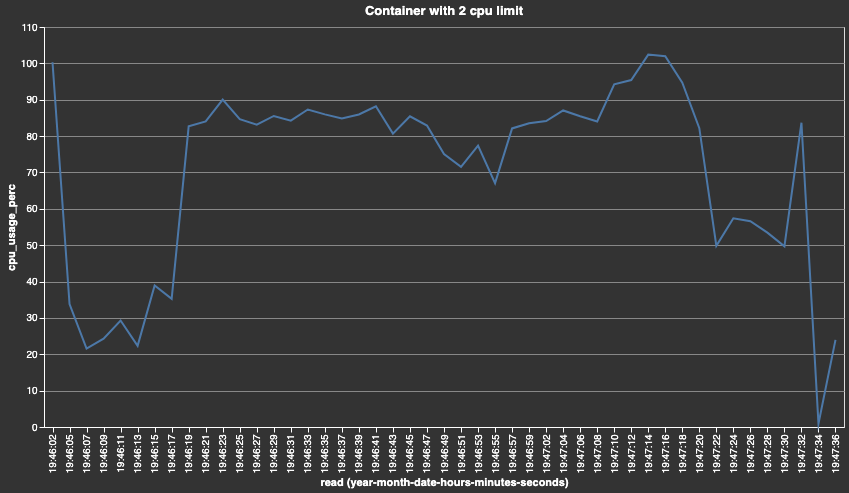

In [6]:
chart = generate_chart(run_with_num_cpu(2))
print_relevant_logs()
chart

19:48:51.504912 [info ] [MainThread]: Found 2000 models, 6000 tests, 0 snapshots, 0 analyses, 165 macros, 0 operations, 0 seed files, 0 sources, 0 exposures, 0 metrics
19:48:52.838806 [debug] [MainThread]: Acquiring new postgres connection "master"



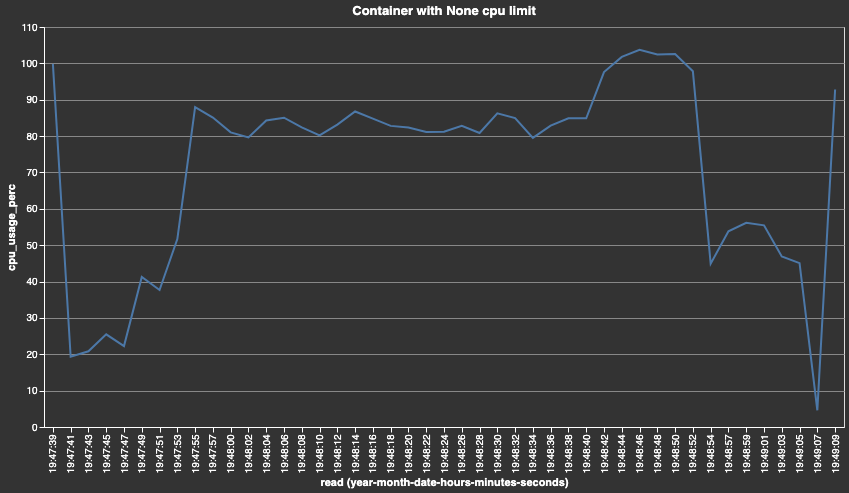

In [7]:
chart = generate_chart(run_with_num_cpu())
print_relevant_logs()
chart

### Appendix

Interestingly running with `--cpus 2` or without any limits does not make the dbt container use more cpu for some reason. I was interested to see if we can get some stats on my machine that shows more than 100% usage or not so I ran the stress tests described here https://www.thorsten-hans.com/docker-container-cpu-limits-explained/.

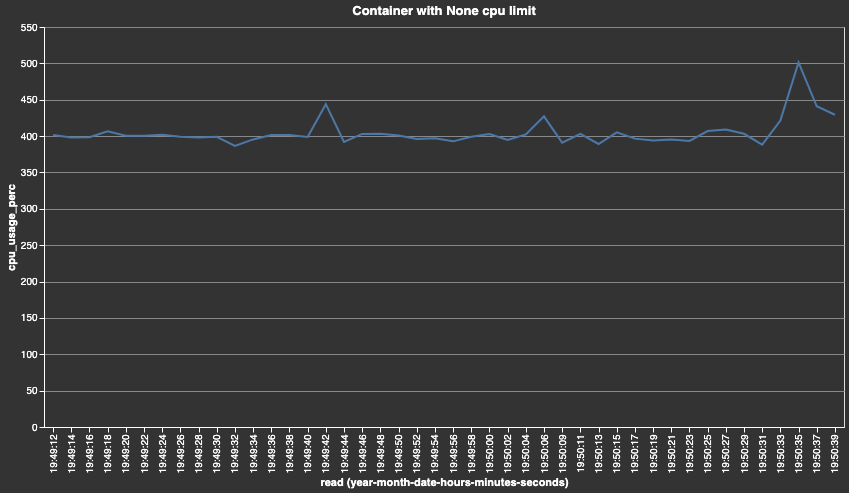

In [8]:
cmd = "docker run --name stress_app --rm progrium/stress -c 8 -t 90s".split(" ")
run_stress = subprocess.Popen(cmd, stdout=subprocess.PIPE)

session = requests_unixsocket.Session()
data = []

while run_stress.poll() != 0:
    r = session.get('http+unix://%2Fvar%2Frun%2Fdocker.sock/containers/stress_app/stats?stream=false')
    if r.status_code == 200:
        try:
            data.append(r.json())
        except:
            pass

data = [_ for _ in data if _["read"] != "0001-01-01T00:00:00Z"]
generate_chart((data, None))


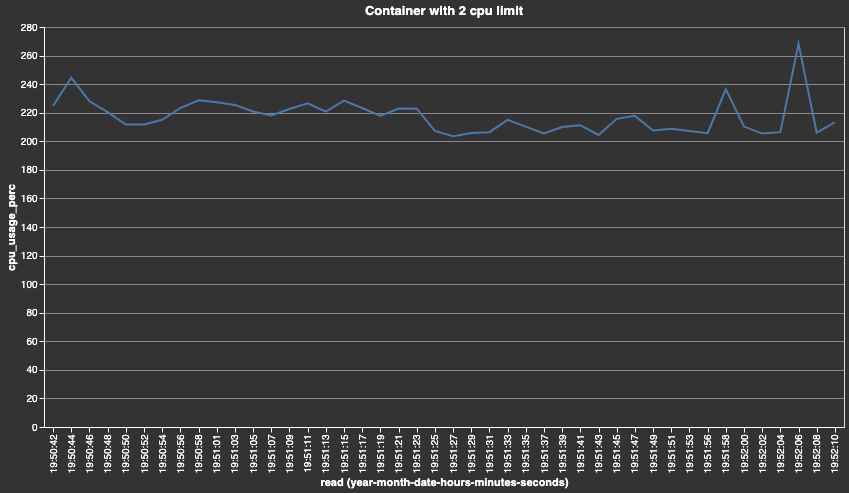

In [9]:
cmd = "docker run --name stress_app --cpus 2 --rm progrium/stress -c 8 -t 90s".split(" ")
run_stress = subprocess.Popen(cmd, stdout=subprocess.PIPE)

session = requests_unixsocket.Session()
data = []

while run_stress.poll() != 0:
    r = session.get('http+unix://%2Fvar%2Frun%2Fdocker.sock/containers/stress_app/stats?stream=false')
    if r.status_code == 200:
        try:
            data.append(r.json())
        except:
            pass

data = [_ for _ in data if _["read"] != "0001-01-01T00:00:00Z"]
generate_chart((data, 2))

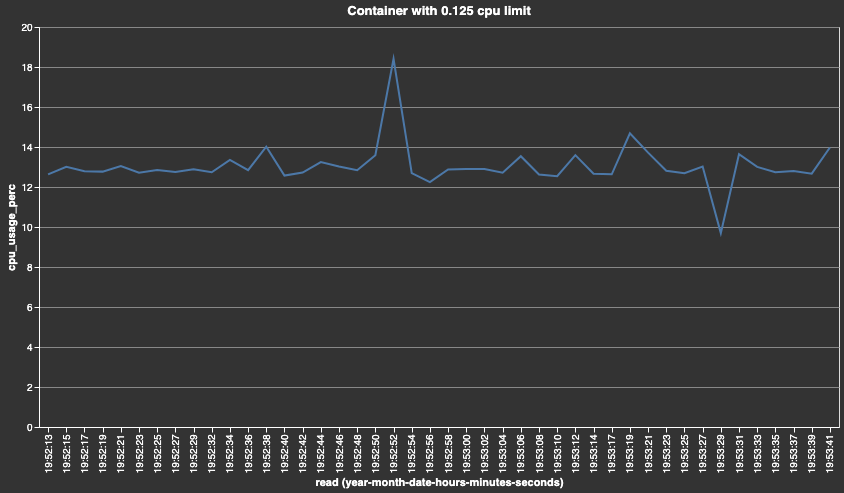

In [10]:
cmd = "docker run --name stress_app --cpus 0.125 --rm progrium/stress -c 8 -t 90s".split(" ")
run_stress = subprocess.Popen(cmd, stdout=subprocess.PIPE)

session = requests_unixsocket.Session()
data = []

while run_stress.poll() != 0:
    r = session.get('http+unix://%2Fvar%2Frun%2Fdocker.sock/containers/stress_app/stats?stream=false')
    if r.status_code == 200:
        try:
            data.append(r.json())
        except:
            pass

data = [_ for _ in data if _["read"] != "0001-01-01T00:00:00Z"]
generate_chart((data, 0.125))